# Figures for 2018 ADAP Proposal

- UNWISE_COADDS_DIR
- UNWISE_COADDS_TIMERESOLVED_DIR
--in theory, set by "unwise_coadds" and "unwise_coadds_timeresolved" modules -- but do these have a canonical place where they live at NERSC?

- DUST_DIR
--SFD dust maps -- set by "dust" module

- GAIA_CAT_DIR (/project/projectdirs/cosmo/work/gaia/chunks-gaia-dr2-astrom/)
- GAIA_CAT_VER=2
--no module for these ones, yet

- PS1CAT_DIR (/project/projectdirs/cosmo/work/ps1/cats/chunks-qz-star-v3/)
--only required during calibration; not set in a module

- Tycho-2 -- current, a file within $LEGACY_SURVEY_DIR, but we should probably make this an external product!

- external catalogs that we cross-match to -- I don't even know how these are identified


So, how should we handle these?  Should we make modules for all of them?  How do we document what these variable were set to for a given Legacy Survey DR?


NEO4:
 /global/projecta/projectdirs/cosmo/work/wise/outputs/merge/neo4/fulldepth

Dustin's unwise:
 /global/projecta/projectdirs/cosmo/work/wise/outputs/merge/neo3/fulldepth:/global/project/projectdirs/cosmo/data/unwise/allwise/unwise-coadds/fulldepth
 

In [38]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from astropy.table import Table, vstack

In [26]:
%matplotlib inline

In [2]:
LSLGAdir = os.getenv('LSLGA_DIR')
adapdir = os.path.join(os.getenv('HOME'), 'repos', 'papers', 'grants', 'nasa-adap-2018')

In [3]:
PIXSCALE = 0.262

In [4]:
parent = Table.read(os.path.join(LSLGAdir, 'sample', 'large-galaxies-parent.fits'))

### Galaxy montage

Demonstrate the range of galaxies and environments the atlas will span.  This will likely be the first figure, so do we want to include the GALEX + WISE data?

In [5]:
def make_montage(montage, jpg_clobber=False, png_clobber=False, montage_clobber=False):
    from PIL import Image, ImageDraw, ImageFont

    barlen = np.round(60.0 / PIXSCALE).astype('int') # [1 arcmin in pixels]
    fonttype = os.path.join(LSLGAdir, 'cutouts', 'Georgia.ttf')    
    
    cutouturl = 'http://legacysurvey.org/viewer-dev/jpeg-cutout'

    # Get the viewer cutouts
    for gal in montage:
        size = np.ceil(gal['d25'] * gal['factor'] * 60 / PIXSCALE).astype(np.int)
        
        imageurl = '{}/?ra={:.8f}&dec={:.8f}&pixscale={:.3f}&size={:g}&layer={}'.format(
            cutouturl, gal['ra'], gal['dec'], PIXSCALE, size, gal['layer'])
    
        jpgfile = os.path.join(adapdir, 'montage', '{}.jpg'.format(gal['galaxy']))
        cmd = 'wget --continue -O {:s} "{:s}"' .format(jpgfile, imageurl)
    
        if os.path.isfile(jpgfile) and not jpg_clobber:
            print('File {} exists...skipping.'.format(jpgfile))
        else:
            if os.path.isfile(jpgfile):
                os.remove(jpgfile)
            print(cmd)
            os.system(cmd)

        # Add labels
        pngfile = jpgfile.replace('.jpg', '.png')
        if os.path.isfile(jpgfile):
            if os.path.isfile(pngfile) and not png_clobber:
                print('File {} exists...skipping.'.format(pngfile))
            else:
                im = Image.open(jpgfile)
                sz = im.size
                fntsize = np.round(sz[0]/28).astype('int')
                width = np.round(sz[0]/175).astype('int')
                font = ImageFont.truetype(fonttype, size=fntsize)
                draw = ImageDraw.Draw(im)

                draw.text((0+fntsize*2, 0+fntsize*2), gal['galaxy'].replace('_', ' '), font=font)
    
                # Add a scale bar--
                x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
                draw.line((x0, yy, x1, yy), fill='white', width=width)
                im.save(pngfile)    
                
    # Make the final montage.
    montagefile = os.path.join(adapdir, 'galaxy-montage.png')
    ncol, nrow = 4, 1
    if os.path.isfile(montagefile) and not montage_clobber:
        print('File {} exists...skipping.'.format(montagefile))
    else:
        cmd = 'montage -bordercolor white -borderwidth 1 -tile {}x{} -geometry 256x256 '.format(ncol, nrow)
        cmd = cmd+' '.join([os.path.join(adapdir, 'montage', '{}.png'.format(gg)) for gg in montage['galaxy']])
        cmd = cmd+' {}'.format(montagefile)
        print(cmd)
        os.system(cmd)        
        print('Writing {}'.format(montagefile))
                

In [6]:
w1 = np.where(parent['galaxy'] == 'NGC3938')[0]
w2 = np.where(parent['galaxy'] == 'NGC5322')[0]
w3 = np.where(parent['galaxy'] == 'IC4182')[0]
w4 = np.where(parent['galaxy'] == 'PGC044711')[0]
these = np.hstack( (w1, w2, w3, w4) )
montage = parent[these]
montage['layer'] = ['mzls+bass-dr6', 'mzls+bass-dr6', 'mzls+bass-dr6', 'decals-dr5']
montage['factor'] = [2.5, 2.5, 2.5, 3.5]
montage['galaxy'][3] = 'CGCG071-093_Group'
montage

galaxy,pgc,objtype,ra,dec,type,bar,ring,multiple,compactness,t,d25,r25,pa,bt,it,kt,modbest,z,sb_d25,mag,groupid,designation,wise_ra,wise_dec,cntr,w1mpro,w1sigmpro,w2mpro,w2sigmpro,w3mpro,w3sigmpro,w4mpro,w4sigmpro,nb,na,cc_flags,ext_flg,ph_qual,w1mag,w1sigm,w2mag,w2sigm,w3mag,w3sigm,w4mag,w4sigm,tmass_key,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass,inwise,layer,factor
bytes28,int64,bytes2,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes20,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,bool,str13,float64
NGC3938,37229,G,178.2058515,44.1207736,Sc,nan,nan,nan,nan,5.1,5.39511,0.104713,nan,10.875,nan,7.861,30.869,0.00269586,23.1635,10.875,42168,J115249.43+440714.8,178.2059666,44.1207889,1789143901351039886,10.617,0.024,10.629,0.021,8.191,0.036,5.813,0.053,1,0,0000,5,AAAA,10.48,0.019,10.442,0.024,7.651,0.123,5.034,0.147,481322632,13.019,0.061,12.523,0.087,12.567,0.104,True,mzls+bass-dr6,2.5
NGC5322,49044,G,207.313452,60.1904759,E,nan,nan,nan,nan,-4.8,5.62341,0.161065,95.0,11.049,nan,7.188,32.444,0.00600782,23.4275,11.049,55884,J134915.28+601125.9,207.3136877,60.1905346,2070160501351018878,8.697,0.022,8.688,0.02,7.758,0.018,6.193,0.046,1,0,0000,5,AAAA,8.712,0.006,8.753,0.006,7.597,0.009,5.962,0.033,648499797,11.079,0.067,10.406,0.083,9.915,0.053,True,mzls+bass-dr6,2.5
IC4182,45314,G,196.455276,37.6046589,Sm,nan,nan,nan,nan,8.8,6.01174,0.108893,nan,12.589,nan,10.064,28.203,0.00104572,25.1125,12.589,51164,NULL,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,mzls+bass-dr6,2.5
CGCG071-093_Group,44711,G,195.0304245,8.6986047,S0,nan,nan,M,nan,-2.0,0.672977,0.115611,24.71,14.991,13.67,11.381,36.589,0.0466833,22.7595,14.991,48492,J130007.29+084155.1,195.0304106,8.6986445,1945109001351023498,11.882,0.022,11.703,0.022,8.782,0.026,6.954,0.084,1,0,0000,5,AAAA,11.716,0.006,11.517,0.009,8.38,0.018,6.45,0.096,892108157,14.213,0.083,13.581,0.091,13.184,0.091,True,decals-dr5,3.5


In [7]:
make_montage(montage, jpg_clobber=False, png_clobber=False, montage_clobber=False)

File /Users/ioannis/repos/papers/grants/nasa-adap-2018/montage/NGC3938.jpg exists...skipping.
File /Users/ioannis/repos/papers/grants/nasa-adap-2018/montage/NGC3938.png exists...skipping.
File /Users/ioannis/repos/papers/grants/nasa-adap-2018/montage/NGC5322.jpg exists...skipping.
File /Users/ioannis/repos/papers/grants/nasa-adap-2018/montage/NGC5322.png exists...skipping.
File /Users/ioannis/repos/papers/grants/nasa-adap-2018/montage/IC4182.jpg exists...skipping.
File /Users/ioannis/repos/papers/grants/nasa-adap-2018/montage/IC4182.png exists...skipping.
File /Users/ioannis/repos/papers/grants/nasa-adap-2018/montage/CGCG071-093_Group.jpg exists...skipping.
File /Users/ioannis/repos/papers/grants/nasa-adap-2018/montage/CGCG071-093_Group.png exists...skipping.
File /Users/ioannis/repos/papers/grants/nasa-adap-2018/galaxy-montage.png exists...skipping.


### WISE surface brightness profile

Demonstrate the improved depth of the NEO3 data vs unWISE by generating the azimuthally averaged surface brightness profile in W1 and W2.

```bash

salloc -N 1 -C haswell -t 00:60:00 --qos interactive -L SCRATCH,project
source ~/software/develop-legacysurveys-code

export UNWISE_COADDS_DIR=/global/cscratch1/sd/ameisner/unwise-coadds/fulldepth_neo4:/global/project/projectdirs/cosmo/data/unwise/allwise/unwise-coadds/fulldepth
wise-galex-cutouts -r 207.313452 -d 60.1904759 --radius 720 --survey-dir /global/projecta/projectdirs/cosmo/data/legacysurvey/dr6 --prefix NGC5322 

export UNWISE_COADDS_DIR=/global/project/projectdirs/cosmo/data/unwise/allwise/unwise-coadds/fulldepth
wise-galex-cutouts -r 207.313452 -d 60.1904759 --radius 720 --survey-dir /global/projecta/projectdirs/cosmo/data/legacysurvey/dr6 --prefix NGC5322-AllWISE

```

In [34]:
from photutils import CircularAperture, aperture_photometry, CircularAnnulus
pixscale = 2.75 / 2
img = fitsio.read(os.path.join(adapdir, 'wise-sbprofiles', 'NGC5322-W1-image.fits'))
img /= pixscale**2

H, W = img.shape
dr = 3
rin = np.arange(1, H-dr, dr)
rout = rin + dr

phot = []
for r1, r2 in zip(rin, rout):
    aper = CircularAnnulus(( H / 2, W / 2), r_in=r1, r_out=r2)
    phot.append(aperture_photometry(img, aper))
phot = vstack(phot)
#phot

In [61]:
def wise_ellipsefit(img):
    from mge.find_galaxy import find_galaxy
    from photutils.isophote import (EllipseGeometry, Ellipse, EllipseSample,
                                    Isophote, IsophoteList)
    from photutils.isophote.sample import CentralEllipseSample
    from photutils.isophote.fitter import CentralEllipseFitter

    gal = find_galaxy(img, nblob=1, binning=3, plot=False, quiet=True)
    geometry = EllipseGeometry(x0=gal.xpeak, y0=gal.ypeak, eps=gal.eps,
                               sma=5, pa=np.radians(gal.pa-90))    
    ellipse = Ellipse(img, geometry=geometry)
    
    integrmode, sclip, nclip, step, fflag = 'bilinear', 3, 0, 0.1, 0.5
    isophot = ellipse.fit_image(minsma=1.0, maxsma=3*gal.majoraxis,
                                integrmode=integrmode, sclip=sclip, nclip=nclip,
                                step=step, fflag=fflag)

    return isophot

In [62]:
%time isophot = wise_ellipsefit(img)

CPU times: user 19.9 s, sys: 145 ms, total: 20 s
Wall time: 16.1 s


In [79]:
from astropy.stats import sigma_clipped_stats
from photutils import make_source_mask
mask = make_source_mask(img, snr=2, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(img, sigma=3.0, mask=mask)
print((mean, median, std)) 
print( 22.5 - 2.5 * np.log10(3 * std) )

(1.2853065847668965, 1.0493785, 1.3556114172081286)
20.9768588185


In [73]:
def wise_sbprofile(isophot, png=None):
    sma = isophot.sma / 60
    mu = 22.5 - 2.5 * np.log10(isophot.intens)
    
    fig, ax = plt.subplots()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ax.scatter(sma, mu)
    ax.set_ylim(22, 11)
    ax.set_xlabel('Galactocentric Radius (arcmin)')
    ax.set_ylabel('Surface Brightness (arcmin)')
    
    if png:
        fig.savefig(png)

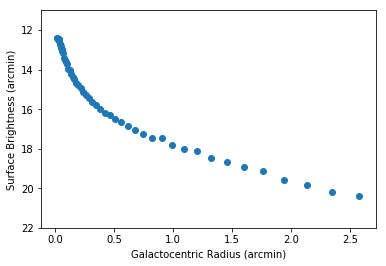

In [74]:
wise_sbprofile(isophot, png=os.path.join(adapdir, 'wise-sbprofiles.png'))

### Multipanel montage of one galaxy in GALEX+LS+WISE

We probably want two different figures, one of a spiral galaxy and another of an earlyish-type.  I'm thinking a 3x3 figure, with data+model+residuals along columns, and GALEX+LS+WISE along rows.

Or this could be a Nx3 where N is some number of galaxies and the three columns are GALEX+LS+WISE.

### Sample selection & properties

* magnitude vs D(25)
* spatial distribution of the sample